In [1]:
from matplotlib import pyplot as plt
from matplotlib import cm
from utils import *

plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams["figure.dpi"] = 300

filename = 'STF_Si_L768_Th85.5_D0_N8388608_1663375572'

grid, dep, params = loadSparse('structures/'+ filename + '.npz')
dense = matrixFromSparse(grid)

In [161]:
from ipywidgets import interact

@interact(x=(0, dense.shape[0]-1))
def show_slice(x):
    plt.subplot(111)
    plt.imshow(dense[x,:,:], cmap="gray", vmax=np.amax(dense[:,:,:]), vmin=0)
    plt.show()

interactive(children=(IntSlider(value=46, description='x', max=92), Output()), _dom_classes=('widget-interact'…

In [2]:
import scipy.ndimage

grid_fill = scipy.ndimage.binary_fill_holes(np.tile(np.where(dense > 0, 1, 0), (1,1,1)))
print('Density: {:.3f}'.format(np.sum(grid_fill[1:,:,:])/((grid_fill.shape[0]-1) * grid_fill.shape[1] * grid_fill.shape[2])))

Density: 0.207


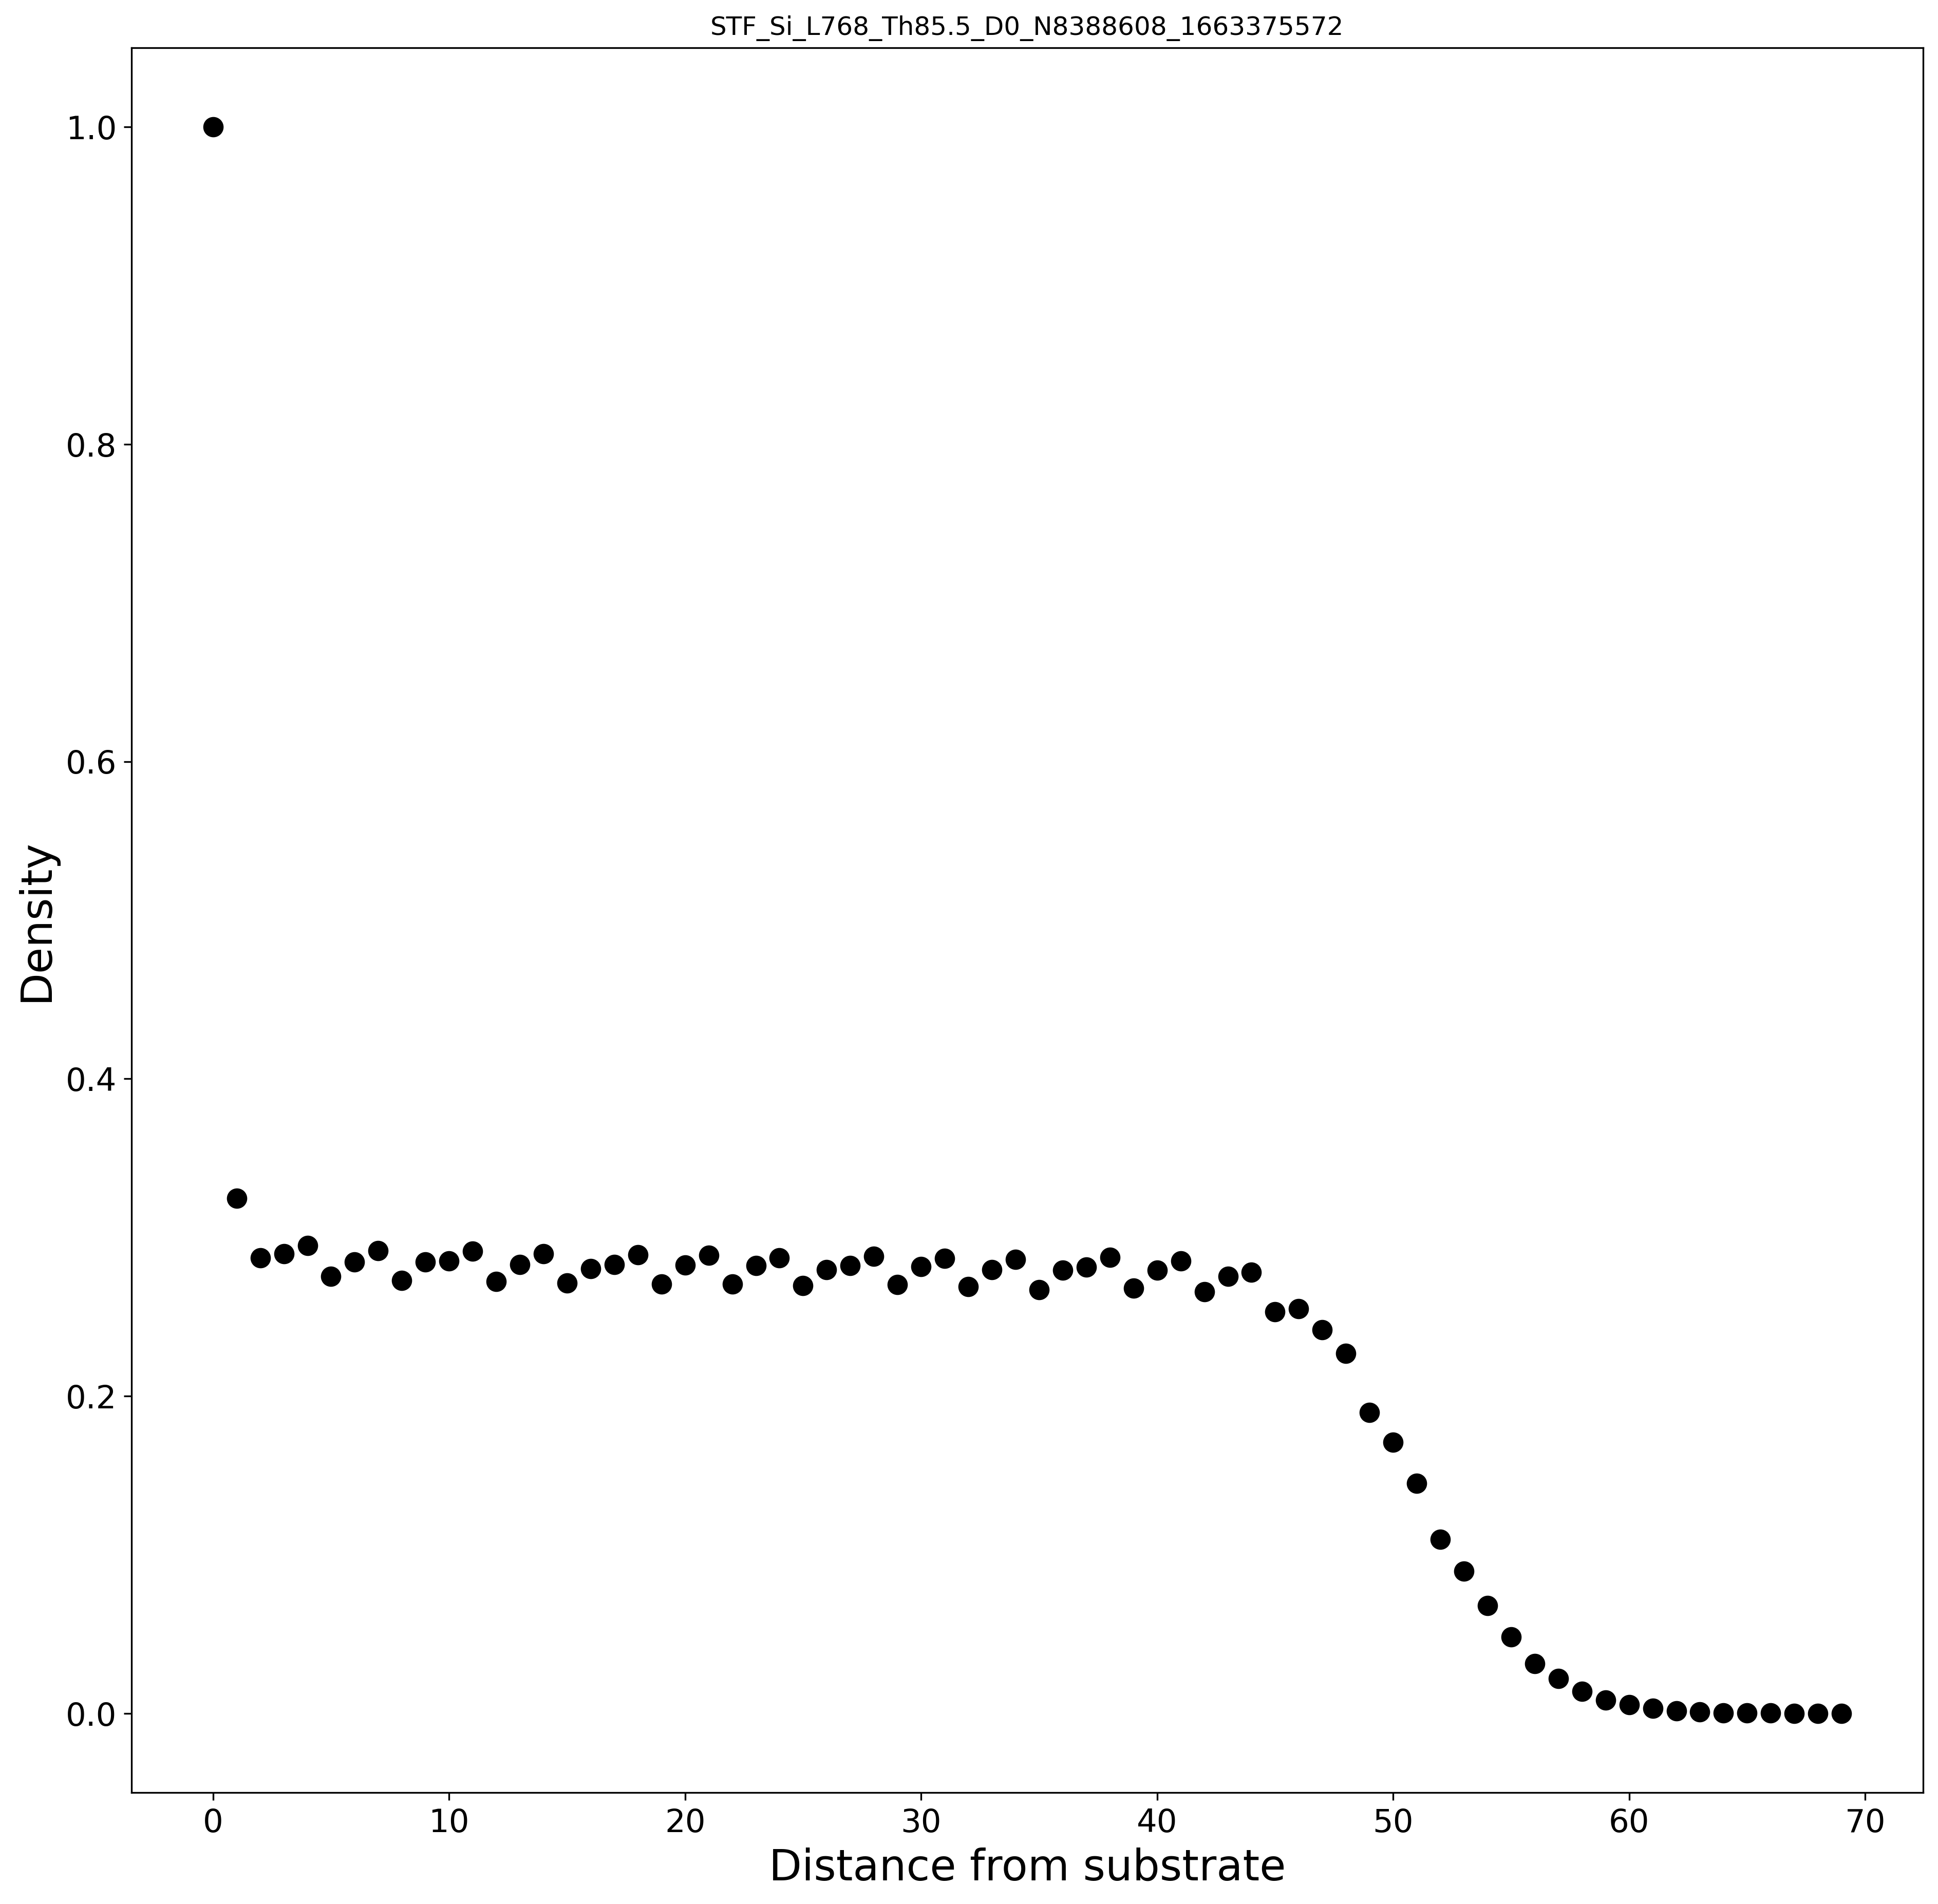

In [3]:
# get density profile
density = grid_fill[:,:,:]/(grid_fill.shape[1] * grid_fill.shape[2])
density = np.sum(density, axis=(1,2))

fig, ax = plt.subplots()
ax.plot(density, 'k.', linewidth=3, markersize=15, markeredgewidth=2, markerfacecolor='k')
ax.set_xlabel('Distance from substrate', fontsize=20)
ax.set_ylabel('Density', fontsize=20)
ax.set_title(filename)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

fig.savefig('data/density/' + filename + '.png')

In [4]:
low = 10
up = 50
print('Density: {:.3f}'.format(np.sum(grid_fill[low:up,:,:])/((up-low) * grid_fill.shape[1] * grid_fill.shape[2])))

Density: 0.274


Axis X:
	Mean of data: -0.048
	Mean of fit: 0.045
	STDEV: 2.209
Axis Y:
	Mean of data: -0.041
	Mean of fit: 0.056
	STDEV: 2.211
Axis Z:
	Mean of data: -0.769
	Mean of fit: -0.785
	STDEV: 2.025


<ipython-input-4-24adef6100af>:12: RuntimeWarning: invalid value encountered in double_scalars
  return amp * lam**k * x**(k-1) * np.exp(-lam*x)/factorial(k-1)
<ipython-input-4-24adef6100af>:12: RuntimeWarning: overflow encountered in exp
  return amp * lam**k * x**(k-1) * np.exp(-lam*x)/factorial(k-1)


Distance:
	Mean of data: 3.473
	Mean of fit: 3.076
	STDEV: 1.550


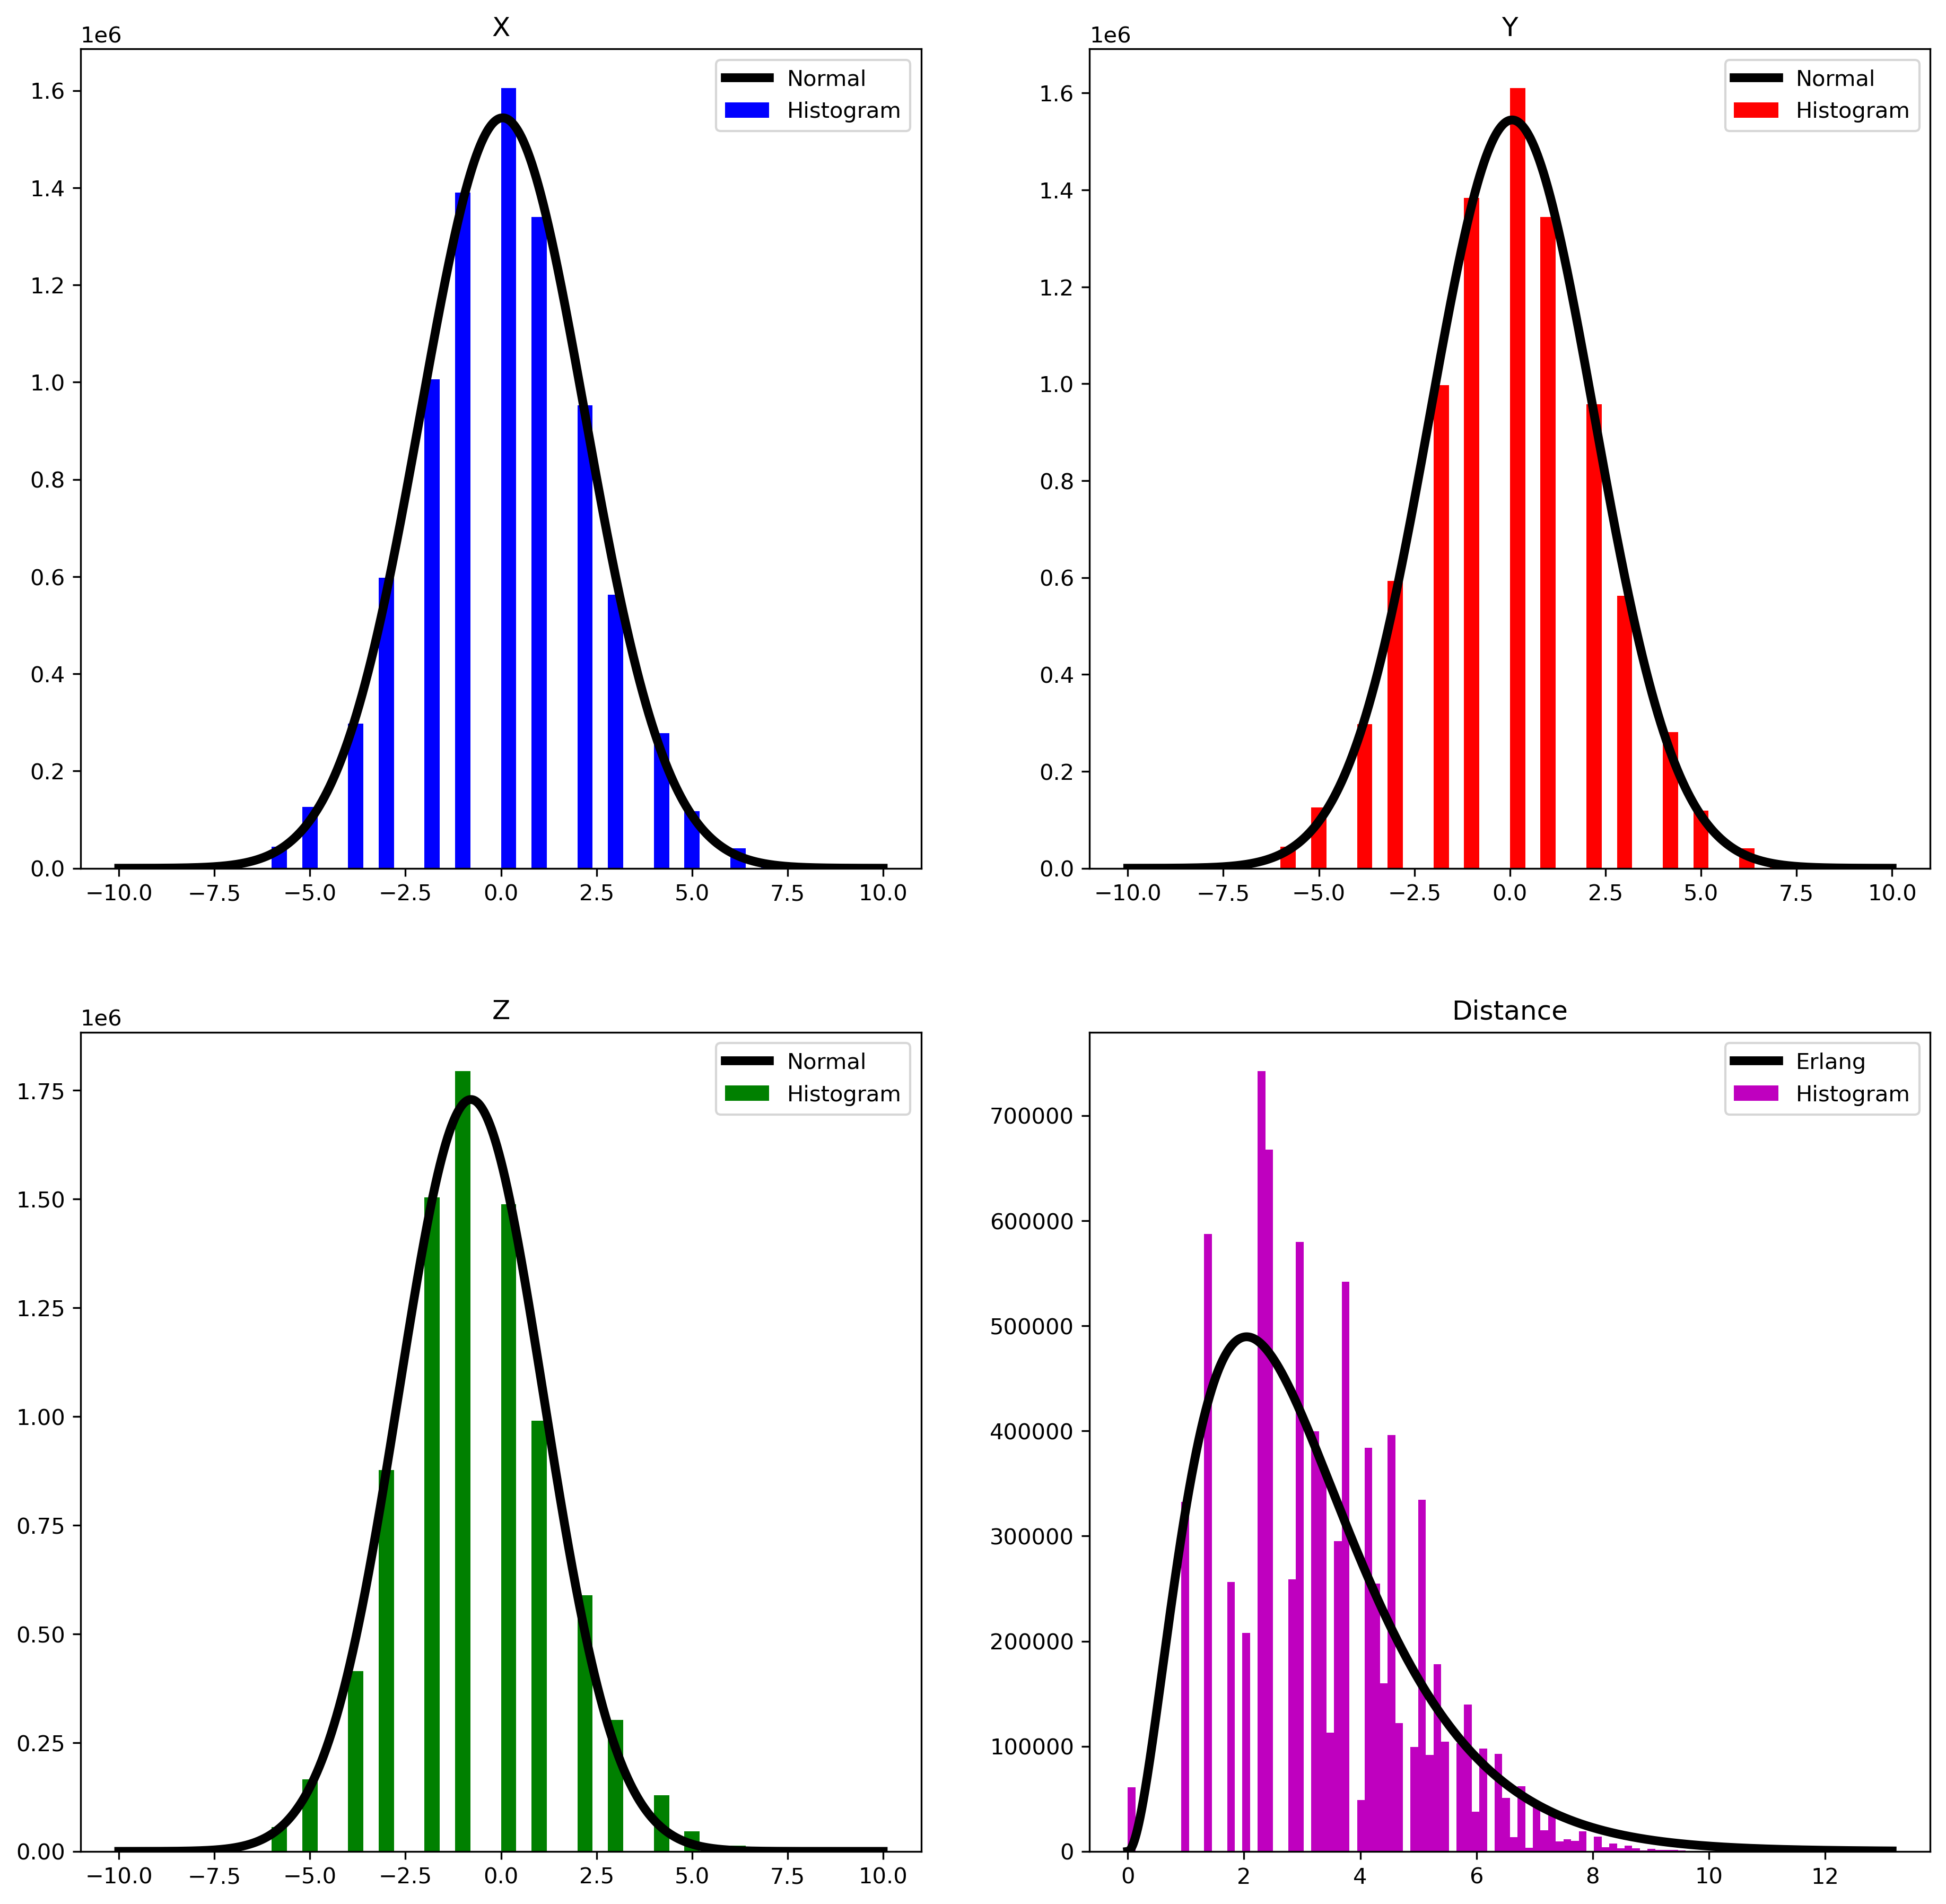

In [4]:
from scipy.optimize import curve_fit
from scipy.special import factorial

def gaussian(x, mean, amp, standard_deviation):
    return amp * np.exp( - (x - mean)**2 / (2*standard_deviation ** 2))

def poisson(k, lam, amp):
    return amp*lam**k*np.exp(-lam)/factorial(k)

# similar to cts poisson
def erlang(x, lam, amp, k):
    return amp * lam**k * x**(k-1) * np.exp(-lam*x)/factorial(k-1)

# only works for 0 mean normals
def chi_dist(x):
    gamma_15 = 0.886227
    return amp * (x**2*np.exp(-x**2/2))/(2**1.5*gamma_15)

def chi_dist_nonzero(x, lam, amp):
    #(exp((-x^2+lambda^2)/2) x^k lambda)/((lambda*x)^(k/2)) I_{k/2-1}(lambda x)
    b_0p5 = 0.7978845608028654 * np.cos(1.5708 - x)
    num = np.exp(-(x**2 + lam**2)/2) * x**1.5 * lam
    den = (lam * x)**1.5
    return amp * num / den * b_0p5

def calculateMeanDists(adist, sdist):
    #sdist = np.sqrt(adist[:,0]**2 + adist[:,1]**2 + adist[:,2]**2)
    colors = [['b', 'r'], ['g', 'm']]
    axis = ['X', 'Y', 'Z', 'Distance']
    title = []
    
    width = 10
    
    # fit distances with histograms
    fig, ax = plt.subplots(2,2)
    for ii in range(2):
        for jj in range(2):
            if ii*2 + jj < 3:
                mat = np.asarray(adist[:,ii*2 + jj])
                bin_heights, bin_borders, _ = ax[ii,jj].hist(mat, bins=50, color=colors[ii][jj], rwidth=1, align='mid', label='Histogram')
            else:
                mat = sdist
                bin_heights, bin_borders, _ = ax[ii,jj].hist(mat, bins=100, color=colors[ii][jj], rwidth=1, align='mid', label='Histogram')

            bin_centers = bin_borders[:-1] + (np.diff(bin_borders))/2
            bc = []
            bh = []
            for i in range(bin_heights.shape[0]):
                if bin_heights[i] != 0:
                    bc.append(bin_centers[i])
                    bh.append(bin_heights[i])
            if ii*2 + jj < 3:
                popt, _ = curve_fit(gaussian, bc, bh, p0=[0., 25000., 1.])
            else:
                popt, _ = curve_fit(erlang, bc, bh, p0=[1., 25000., 1.])


            x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
            if ii*2 + jj < 3:
                print("Axis {}:\n\tMean of data: {:.3f}\n\tMean of fit: {:.3f}\n\tSTDEV: {:.3f}".format(axis[ii*2 + jj], np.mean(mat), popt[0], np.std(mat)))
                ax[ii,jj].plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='Normal', color='k', linewidth=4)
            else:
                print("{}:\n\tMean of data: {:.3f}\n\tMean of fit: {:.3f}\n\tSTDEV: {:.3f}".format(axis[ii*2 + jj], np.mean(mat), popt[2]/popt[0], np.std(mat)))
                ax[ii,jj].plot(x_interval_for_fit, erlang(x_interval_for_fit, *popt), label='Erlang', color='k', linewidth=4)
            ax[ii,jj].legend()
            ax[ii,jj].set_title(axis[ii*2 + jj])
filename = 'STF_Si_L768_x-1_Th85.5_D10_N8388608_1660218562'
dists = np.load('data/diffusion_lengths/' + filename + '.npz', allow_pickle=True)['arr_0']
adist = dists[:,:3]
sdist = dists[:,3]
calculateMeanDists(adist, sdist)

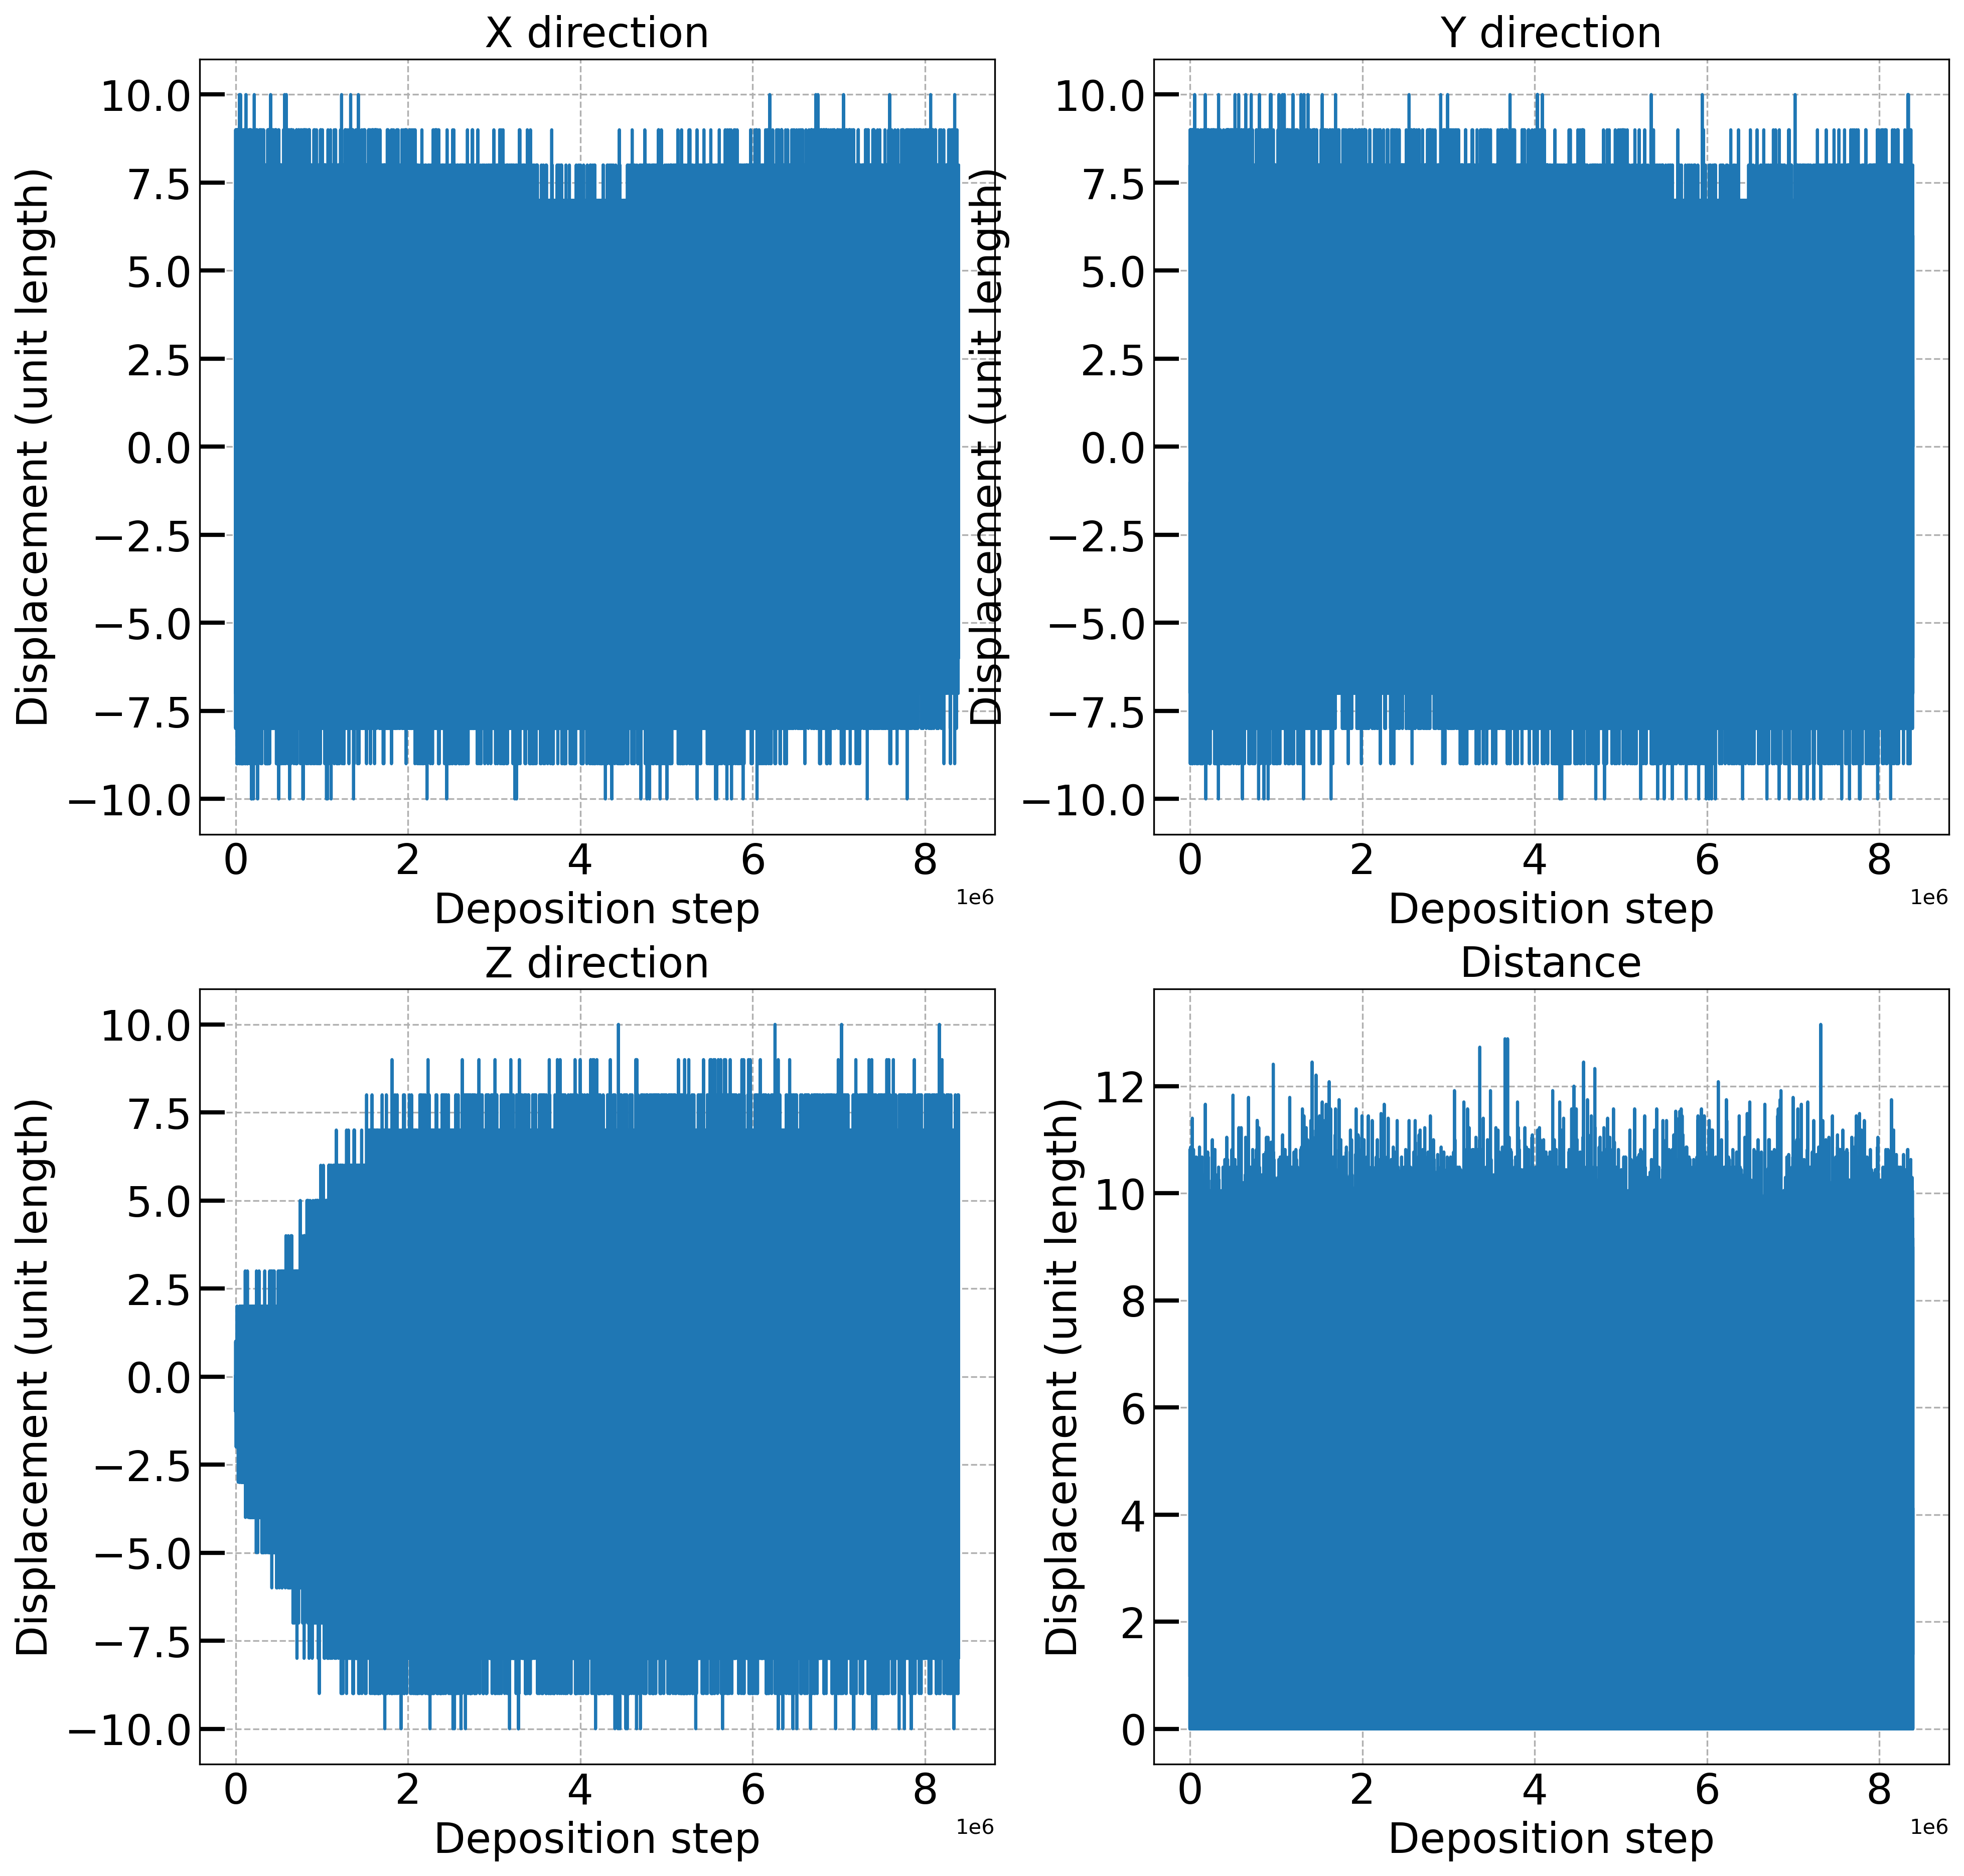

In [5]:
import matplotlib as mp

mp.rcParams['agg.path.chunksize'] = 10000


fig, ax = plt.subplots(2,2)
for b in ax:
    for a in b:
        a.set_ylabel('Displacement (unit length)', fontsize=20)
        a.set_xlabel('Deposition step', fontsize=20)
        a.tick_params(axis='y', which='major', direction='in', length=12, width=2, labelsize=20)
        a.tick_params(axis='x', which='major', direction='in', length=0, width=2, labelsize=20)
        a.grid(True, linestyle='--')
ax[0,0].plot(adist[:,0])
ax[0,0].set_title("X direction", fontsize=20)
ax[0,1].plot(adist[:,1])
ax[0,1].set_title("Y direction", fontsize=20)
ax[1,0].plot(adist[:,2])
ax[1,0].set_title("Z direction", fontsize=20)
ax[1,1].plot(sdist)
ax[1,1].set_title("Distance", fontsize=20)
plt.show()